In [17]:
from tensorflow import keras
from tensorflow.keras import layers
from models.vqvae2 import *
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display

In [2]:
model = VQVAETrainer(latent_dim=None, num_embeddings=None)
model.load_weights("./saved_models/savio_model_1")
model.compile(optimizer=keras.optimizers.Adam())

2021-10-31 14:08:24.470835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [95]:
random_top = tf.random.uniform(shape=[128 * 11], dtype=tf.dtypes.int64, minval=0, maxval=512)
random_bot = tf.random.uniform(shape=[256 * 22], dtype=tf.dtypes.int64, minval=0, maxval=512)

In [103]:
decoded = model.decode_code(random_top, random_bot)

In [104]:
stft = decoded.numpy().reshape(1024, 88)
stft = librosa.db_to_amplitude(stft*-80)

In [105]:
y = librosa.istft(P2R(stft, phase[:-1, :-1]))

Text(0.5, 1.0, 'Reconstructed')

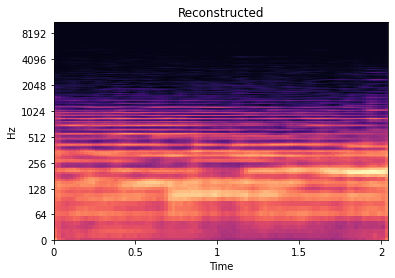

In [106]:
fig, ax = plt.subplots()
img = librosa.display.specshow(decoded.numpy().reshape(1024, 88) * -80.,y_axis='log', x_axis='time', ax=ax)
ax.set_title('Reconstructed')

In [107]:
Audio(y, rate=44100)

In [38]:
fantasie, sr = librosa.load("/Users/jerms/Documents/Music/Bad Recordings/gimpromptu.mp4", sr=44100)

/Users/jerms/.local/share/virtualenvs/new_vae-B5i6JtKw/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [73]:
def P2R(radii, angles):
    return radii * np.exp(1j*angles)

In [101]:
clip =  fantasie[20 * sr : 20 * sr + 2048 * 22]
stft = librosa.stft(clip)
mag = -1 * librosa.amplitude_to_db(np.abs(stft), ref=np.max) / 80.
phase = np.angle(stft)
mag = mag[:-1, :-1].reshape(1, 1024, 88, 1)

In [102]:
random_top, random_bot = model.top_and_bottom_indices(mag)

In [89]:
model_stft = model.vqvae(mag)